## Time Series Analysis on king bolete 1954-2022

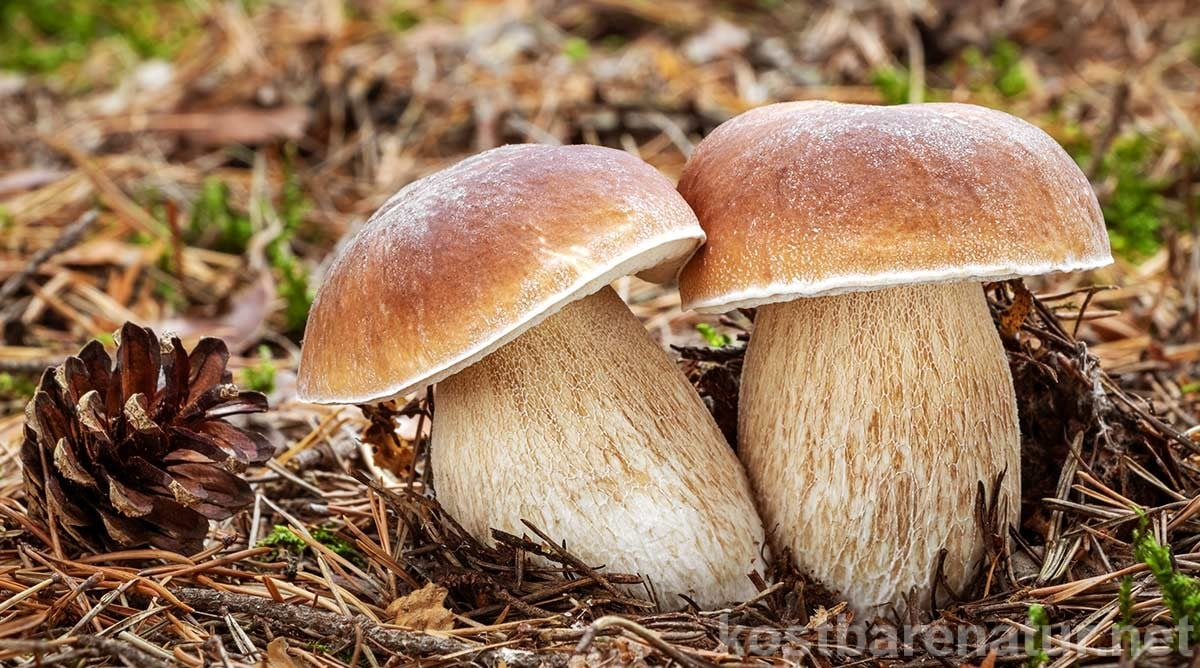

In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("ggplot")

# statsmodel
import statsmodels
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa import stattools
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import ar_select_order
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.api import OLS, add_constant
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

# Import the relevant sklearn packages
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

# Set the figure size to (14,6)
plt.rcParams['figure.figsize'] = (14,6)
plt.rcParams['font.size'] = '14'

import warnings
warnings.filterwarnings(action='ignore')

In [106]:
df= pd.read_csv('output_test_dates_cleaned.csv',sep=';', parse_dates=True, index_col=0, skipinitialspace=True)
df

,total_obs
DATE,
1885-06-09,1
1887-01-08,3
1927-01-10,1
1932-08-17,2
1932-09-24,1
...,...
2022-10-23,1
2022-10-25,1
2022-10-28,4


In [114]:
# Filter the DataFrame to include only rows from June 24, 1954, onwards
df = df.loc['1954-06-24':]

# Create a new column containing the year component of the index
df['year'] = df.index.year

# Group the data by year
grouped = df.groupby('year')


In [116]:
df=grouped.sum()
df

,total_obs
year,
1954,10
1955,1
1956,1
1957,1
1958,2
...,...
2018,49
2019,104
2020,112


# Plot the data

In [117]:
def plot_totalobs(df, title='Daily total king bolete collections since 1954', ylim=True):
    '''
    Custom plotting function for plotting the total observations dataset
    
    Parameters
    ----------
    df : pd.DataFrame
        The data to plot.
    title : str
        The title of the plot
    ylim : bool
        Whether to fix the minimum value of y; defalut is True
    
    Returns
    -------
    Plots the data
    '''
    df.plot()
    plt.title(title)
    plt.ylabel('total amount of king bolete')
    if ylim:
        plt.ylim(ymin=0)
    plt.show()

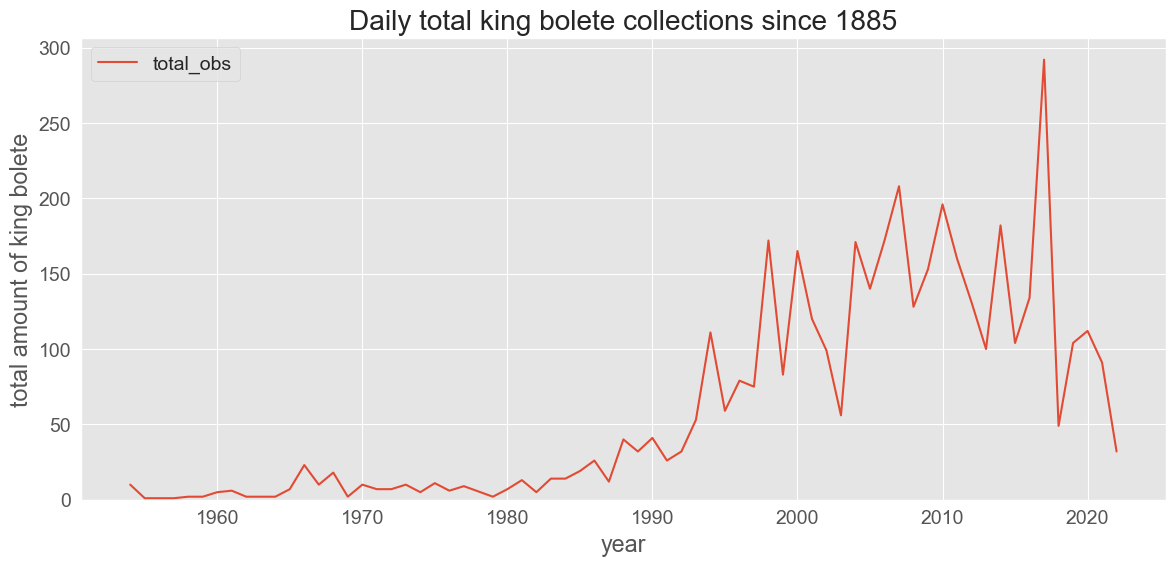

In [118]:
plot_totalobs(df)

# Extract timesteps, seasonal dummies for the whole dataset

In [119]:
# Add timestep feature - for modeling trend
df['timestep'] = range(len(df))
df.head()

,total_obs,timestep
year,,
1954,10,0
1955,1,1
1956,1,2
1957,1,3
1958,2,4


In [179]:
seasonal_dummies = pd.get_dummies(
    df.index, 
    prefix='year',
    drop_first=True).set_index(df.index)
df = df.join(seasonal_dummies)

df.head()


ValueError: columns overlap but no suffix specified: Index(['year_1956', 'year_1957', 'year_1958', 'year_1959', 'year_1960',
       'year_1961', 'year_1962', 'year_1963', 'year_1964', 'year_1965',
       'year_1966', 'year_1967', 'year_1968', 'year_1969', 'year_1970',
       'year_1971', 'year_1972', 'year_1973', 'year_1974', 'year_1975',
       'year_1976', 'year_1977', 'year_1979', 'year_1980', 'year_1981',
       'year_1982', 'year_1983', 'year_1984', 'year_1985', 'year_1986',
       'year_1987', 'year_1988', 'year_1989', 'year_1990', 'year_1991',
       'year_1992', 'year_1993', 'year_1994', 'year_1995', 'year_1996',
       'year_1997', 'year_1998', 'year_1999', 'year_2000', 'year_2001',
       'year_2002', 'year_2003', 'year_2004', 'year_2005', 'year_2006',
       'year_2007', 'year_2008', 'year_2009', 'year_2010', 'year_2011',
       'year_2012', 'year_2013', 'year_2014', 'year_2015', 'year_2016',
       'year_2017', 'year_2018', 'year_2019', 'year_2020', 'year_2021',
       'year_2022'],
      dtype='object')

In [126]:
X=df.drop('total_obs',axis=1)
y=df['total_obs']

In [127]:
# Run linear regression to get trend-seasonal component
m = LinearRegression()
m.fit(X, y)

LinearRegression()

In [128]:
# Add trend-seasonal component to the data
df['trend_seasonal'] = m.predict(X)
df.head(2)

,total_obs,timestep,trend_seasonal,year_1955,year_1956,year_1957,year_1958,year_1959,year_1960,year_1961,...,year_2013,year_2014,year_2015,year_2016,year_2017,year_2018,year_2019,year_2020,year_2021,year_2022
year,,,,,,,,,,,,,,,,,,,,,
1954,10,0,10.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1955,1,1,1.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Plot the original data and preliminary model

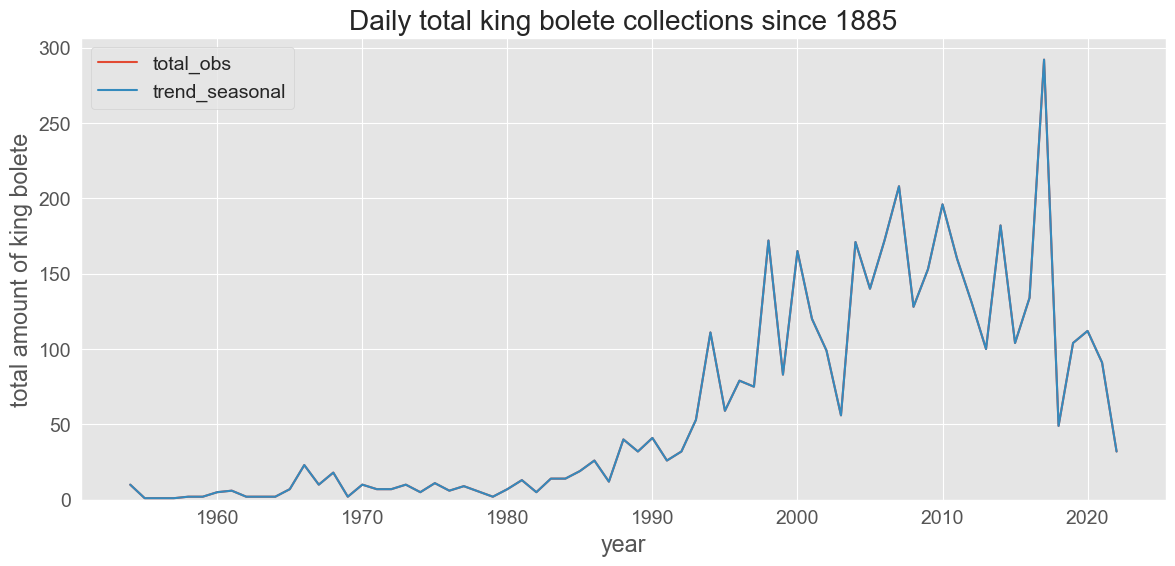

In [129]:
plot_totalobs(df[['total_obs', 'trend_seasonal']]) #u can see that this model includes both trend as well as seasonality

# Extract the remainder

In [130]:
# Add remainder column (We want to extract the part of the model that the trend_seasonal is not able to explain)
df['remainder'] = df['total_obs'] - df['trend_seasonal']
data = df['remainder']
data

year
1954   -5.222489e-12
1955   -1.065814e-13
1956   -1.726619e-12
1957    1.826095e-12
1958   -1.143974e-12
            ...     
2018    5.137224e-12
2019    8.839152e-12
2020    1.020339e-11
2021    7.048584e-12
2022    1.067946e-11
Name: remainder, Length: 68, dtype: float64

In [131]:
from statsmodels.tsa.ar_model import ar_select_order
lags_order = ar_select_order(df['remainder'], maxlag=5)
lags_order.ar_lags



[1]

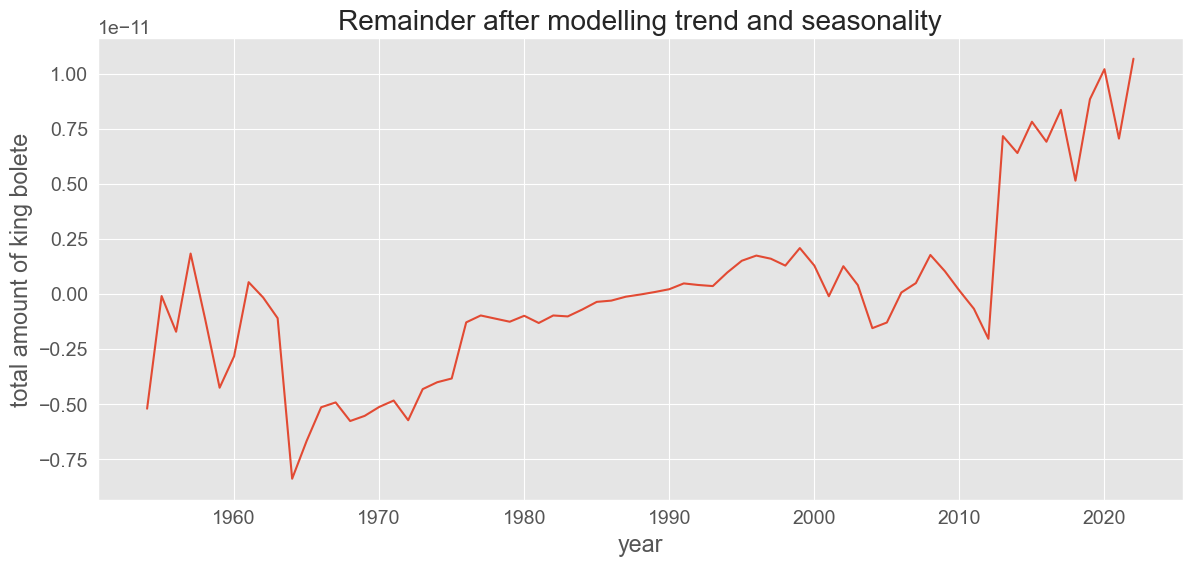

In [132]:
plot_totalobs(df['remainder'], 
             title='Remainder after modelling trend and seasonality', 
             ylim=False)

# Add the lag of the remainder to the training data

In [133]:
# Add lag feature — for modeling remainder
df['lag1'] = df['remainder'].shift(1)
# df['lag2'] = df['remainder'].shift(2)

df.head(2)

,total_obs,timestep,trend_seasonal,year_1955,year_1956,year_1957,year_1958,year_1959,year_1960,year_1961,...,year_2015,year_2016,year_2017,year_2018,year_2019,year_2020,year_2021,year_2022,remainder,lag1
year,,,,,,,,,,,,,,,,,,,,,
1954,10,0,10.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-5.222489e-12,NaN
1955,1,1,1.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-1.065814e-13,-5.222489e-12


In [134]:
df.dropna(inplace=True)
df.head(2)

,total_obs,timestep,trend_seasonal,year_1955,year_1956,year_1957,year_1958,year_1959,year_1960,year_1961,...,year_2015,year_2016,year_2017,year_2018,year_2019,year_2020,year_2021,year_2022,remainder,lag1
year,,,,,,,,,,,,,,,,,,,,,
1955,1,1,1.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-1.065814e-13,-5.222489e-12
1956,1,2,1.0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-1.726619e-12,-1.065814e-13


# Run the full model

In [135]:
# Define X and y for **FULL MODEL**
X_full = df.drop(['total_obs', 'trend_seasonal', 'remainder'], axis=1)
y_full = df['total_obs']

...Feature engineering CHECK - next step: Fit the model and make predictions

In [136]:
X_full

,timestep,year_1955,year_1956,year_1957,year_1958,year_1959,year_1960,year_1961,year_1962,year_1963,...,year_2014,year_2015,year_2016,year_2017,year_2018,year_2019,year_2020,year_2021,year_2022,lag1
year,,,,,,,,,,,,,,,,,,,,,
1955,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-5.222489e-12
1956,2,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.065814e-13
1957,3,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.726619e-12
1958,4,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.826095e-12
1959,5,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.143974e-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018,63,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,8.355983e-12
2019,64,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,5.137224e-12
2020,65,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,8.839152e-12


In [137]:
m_full = LinearRegression()
m_full.fit(X_full, y_full)

LinearRegression()

In [138]:
# Create a new predictions column
df['predictions_full_model'] = m_full.predict(X_full)
df.tail()

,total_obs,timestep,trend_seasonal,year_1955,year_1956,year_1957,year_1958,year_1959,year_1960,year_1961,...,year_2016,year_2017,year_2018,year_2019,year_2020,year_2021,year_2022,remainder,lag1,predictions_full_model
year,,,,,,,,,,,,,,,,,,,,,
2018,49,63,49.0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,5.137224e-12,8.355983e-12,49.0
2019,104,64,104.0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,8.839152e-12,5.137224e-12,104.0
2020,112,65,112.0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1.020339e-11,8.839152e-12,112.0
2021,91,66,91.0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,7.048584e-12,1.020339e-11,91.0
2022,32,67,32.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1.067946e-11,7.048584e-12,32.0


Hint: Timestep, monthly dummies and the lag of the remainder give us the **predictions for the actual data** (not just the remainder).

# Plot the prediction vs total amount of king bolete for the training data

Hint: total_obs, trend_seasonal & predictions_full_model ist exactly the same

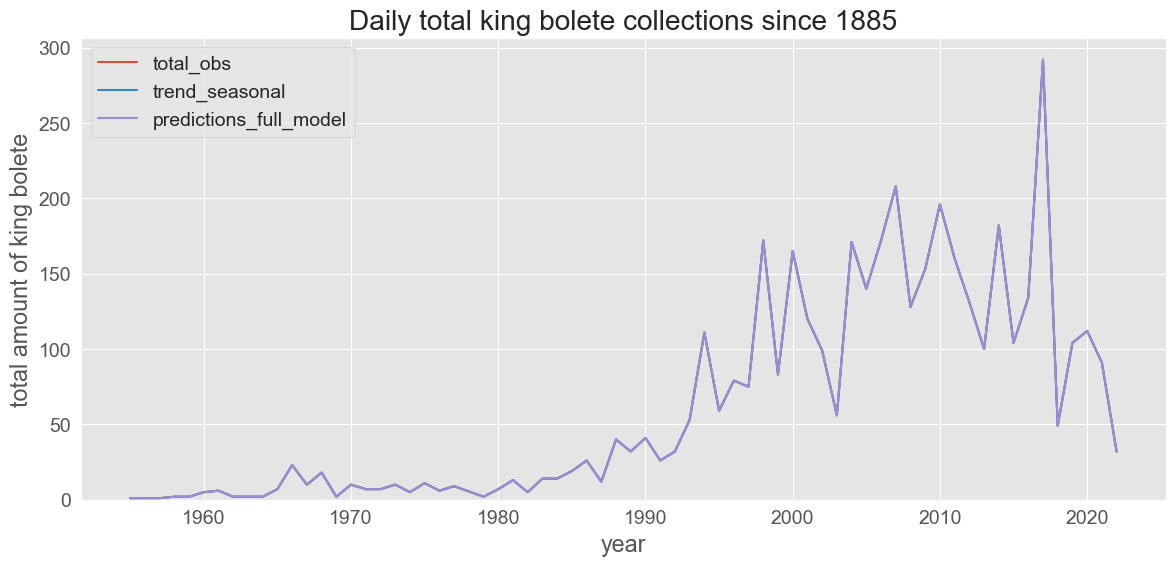

In [139]:
plot_totalobs(df[['total_obs', 'trend_seasonal', 'predictions_full_model']])

Coefficients of the AR equation's terms:

In [141]:
pd.DataFrame(m_full.coef_.reshape(1,69), columns=X_full.columns)

,timestep,year_1955,year_1956,year_1957,year_1958,year_1959,year_1960,year_1961,year_1962,year_1963,...,year_2014,year_2015,year_2016,year_2017,year_2018,year_2019,year_2020,year_2021,year_2022,lag1
0,2.702821,28.058776,25.355955,22.653133,20.950312,18.247491,18.544669,16.841848,10.139027,7.436205,...,52.295138,-28.407683,-1.110505,154.186674,-91.516147,-39.218969,-33.92179,-57.624611,-119.327433,-9.351508e-10


## Evaluate the model

In [142]:
X_full

,timestep,year_1955,year_1956,year_1957,year_1958,year_1959,year_1960,year_1961,year_1962,year_1963,...,year_2014,year_2015,year_2016,year_2017,year_2018,year_2019,year_2020,year_2021,year_2022,lag1
year,,,,,,,,,,,,,,,,,,,,,
1955,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-5.222489e-12
1956,2,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.065814e-13
1957,3,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.726619e-12
1958,4,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.826095e-12
1959,5,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.143974e-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018,63,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,8.355983e-12
2019,64,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,5.137224e-12
2020,65,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,8.839152e-12


In [143]:
# Create a TimeSeriesSplit object
ts_split = TimeSeriesSplit(n_splits=5)

In [144]:
for i, (train_index, validation_index) in enumerate(ts_split.split(X_full, y_full)):
    print(f'The training data for the {i+1}th iteration are the observations {train_index[0]} to {train_index[-1]}')
    print(f'The validation data for the {i+1}th iteration are the observations {validation_index[0]} to {validation_index[-1]}')
    print()

The training data for the 1th iteration are the observations 0 to 11
The validation data for the 1th iteration are the observations 12 to 22

The training data for the 2th iteration are the observations 0 to 22
The validation data for the 2th iteration are the observations 23 to 33

The training data for the 3th iteration are the observations 0 to 33
The validation data for the 3th iteration are the observations 34 to 44

The training data for the 4th iteration are the observations 0 to 44
The validation data for the 4th iteration are the observations 45 to 55

The training data for the 5th iteration are the observations 0 to 55
The validation data for the 5th iteration are the observations 56 to 66



In [145]:
# Create the time series split
time_series_split = ts_split.split(X_full, y_full)

In [146]:
result = cross_val_score(estimator=m_full, X=X_full, y=y_full, cv=time_series_split)
result

array([-5.32006581,  0.06414314, -1.43383761, -1.67814081, -0.4422507 ])

In [148]:
round(result.mean(), 3)

-1.762

Hint: The score is $R^2$ 

## Predict the future

In [156]:
# Create a future data point
timestep = df['timestep'].max() + 1
# months_days = [0] * 39  # array of zeroes
lag1 = df.loc[2022, 'remainder']
# lag2 = df.loc['2022-10-31', 'remainder'] 



In [177]:
X_future = [timestep]
# X_future.extend(months_days)
X_future.append(lag1)
# X_future.append(lag2)
X_future = pd.DataFrame([X_future])
# X_future.columns = X_full.columns
X_future
# Prediction for 2023
m_full.predict(X_future)

ValueError: X has 2 features, but LinearRegression is expecting 69 features as input.

## Augmented Dickey-Fuller Test (ADF)

In [158]:
def print_adf(data):
    
    """ Prints the results of the augmented Dickey Fuller Test"""
    
    adf_stats, p, used_lag, n_obs, levels, information_criterion = adfuller(data)
    
    print(f"""adf_stats: {adf_stats}
            p: {p} 
            used lag: {used_lag} 
            number of observations: {n_obs}
            CI 99%: {levels['1%']}
            CI 95%: {levels['5%']}
            CI 90%: {levels['10%']}
            information criterion (AIC): {information_criterion}
            """)

In [159]:
print_adf(data)

adf_stats: -0.700980475163588
            p: 0.8464954092311527 
            used lag: 1 
            number of observations: 66
            CI 99%: -3.5335601309235605
            CI 95%: -2.9064436883991434
            CI 90%: -2.590723948576676
            information criterion (AIC): -2875.358164943528
            


### Summarization: Log likelihood, AIC, BIC etc.

In [160]:
ar_model = AutoReg(df['remainder'], lags=1, old_names=False).fit()

In [161]:
ar_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:              remainder   No. Observations:                   67
Model:                     AutoReg(1)   Log Likelihood                1683.819
Method:               Conditional MLE   S.D. of innovations              0.000
Date:                Fri, 24 Feb 2023   AIC                          -3361.637
Time:                        14:55:37   BIC                          -3355.068
Sample:                             1   HQIC                         -3359.041
                                   67                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         1.587e-13   2.48e-13      0.640      0.522   -3.27e-13    6.44e-13
remainder.L1     0.9172      0.065     14.186      0.000       0.790       1.044
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0903           +0.0000j            1.0903            0.0000
-----------------------------------------------------------------------------
"""

In [162]:
# # based on that result we would conclude that modeling the remainder as AR(1) gives a slightly better model
# print(ar_1.bic, ar_2.bic, ar_3.bic)

In [163]:
# ar_2.summary()

In [164]:
# ar_3.summary()

## ARIMA

### Revision of the above (Step 1-4)

1) Get the remainder

In [165]:
data

year
1954   -5.222489e-12
1955   -1.065814e-13
1956   -1.726619e-12
1957    1.826095e-12
1958   -1.143974e-12
            ...     
2018    5.137224e-12
2019    8.839152e-12
2020    1.020339e-11
2021    7.048584e-12
2022    1.067946e-11
Name: remainder, Length: 68, dtype: float64

2. Plot the remainder

<AxesSubplot: xlabel='year', ylabel='remainder'>

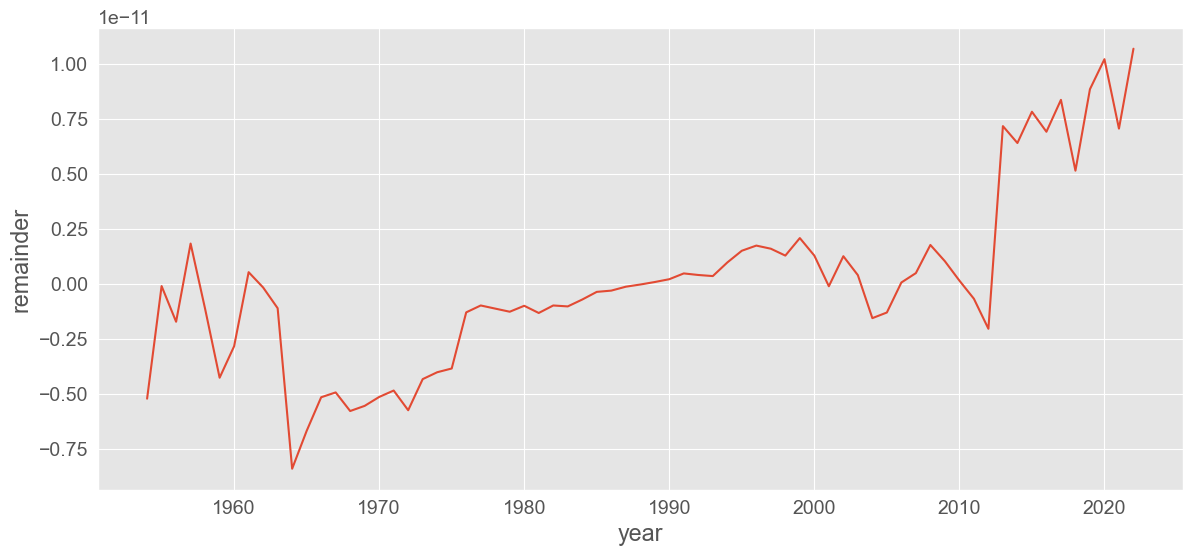

In [166]:
sns.lineplot(data)

3. Inspect the Partial Autocorrelation and use ar_select_order

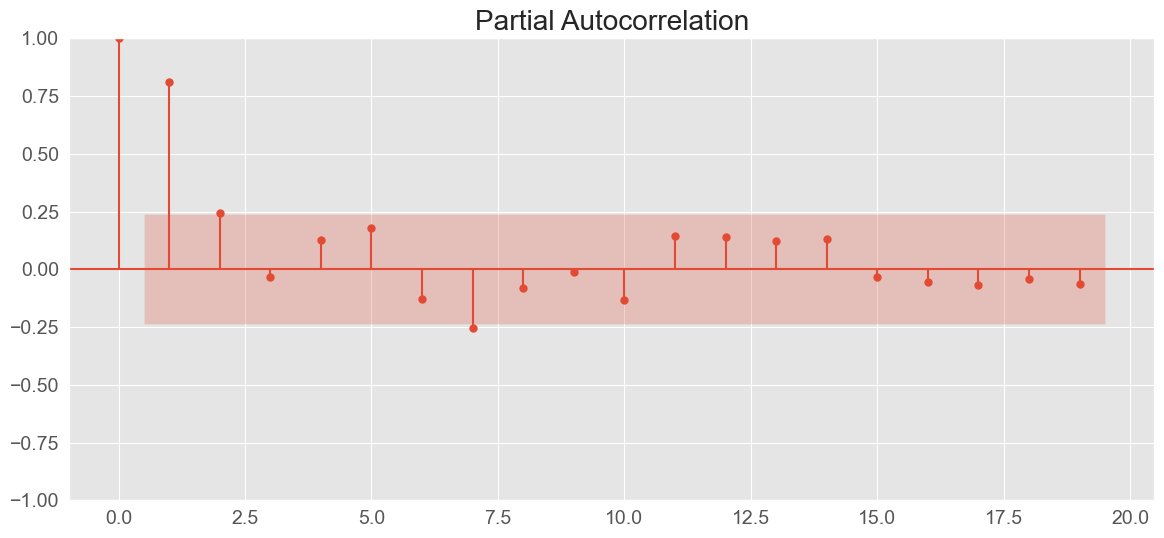

In [167]:
# Plot the partial autocorrelation function
plot_pacf(data);

Inspecting the pacf plot we choose to include 4 lags into our model following the Box-Jenkins-Methodology

In [168]:
# Use ar_select_order
order = ar_select_order(data, maxlag=10)

In [169]:
# How many lags does ar_select_order suggest?
order.ar_lags

[1]

4. Choose number of lags

In [170]:
# Fit a statsmodels AutoReg model
ar_model = AutoReg(data, lags=1).fit()

In [171]:
ar_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:              remainder   No. Observations:                   68
Model:                     AutoReg(1)   Log Likelihood                1707.462
Method:               Conditional MLE   S.D. of innovations              0.000
Date:                Fri, 24 Feb 2023   AIC                          -3408.923
Time:                        14:56:08   BIC                          -3402.309
Sample:                             1   HQIC                         -3406.306
                                   68                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         2.231e-13   2.53e-13      0.882      0.378   -2.73e-13    7.19e-13
remainder.L1     0.8940      0.066     13.629      0.000       0.765       1.023
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1185           +0.0000j            1.1185            0.0000
-----------------------------------------------------------------------------
"""

## ARIMA(1,0,1) process

In [172]:
# Fit an ARIMA model
arima_model = ARIMA(data, order=(1,0,1)).fit()

# order defines (#of AR lags, I, #of MA lags); (p,d,q)
# (1,0,1) - means that we have 1 AR lag and 1 MA lag

In [173]:
# Look at the summary
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              remainder   No. Observations:                   68
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 719.219
Date:                Fri, 24 Feb 2023   AIC                          -1430.438
Time:                        14:56:22   BIC                          -1421.560
Sample:                             0   HQIC                         -1426.920
                                 - 68                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.456e-14   2.06e-23   1.19e+09      0.000    2.46e-14    2.46e-14
ar.L1          0.9690   1.09e-19   8.88e+18      0.000       0.969       0.969
ma.L1         -0.2312   7.04e-21  -3.29e+19      0.000      -0.231      -0.231
sigma2          1e-10    2.4e-10      0.416      0.677   -3.71e-10    5.71e-10
===================================================================================
Ljung-Box (L1) (Q):                   0.28   Jarque-Bera (JB):               108.66
Prob(Q):                              0.60   Prob(JB):                         0.00
Heteroskedasticity (H):               1.05   Skew:                             0.41
Prob(H) (two-sided):                  0.90   Kurtosis:                         9.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

<AxesSubplot: xlabel='year', ylabel='remainder'>

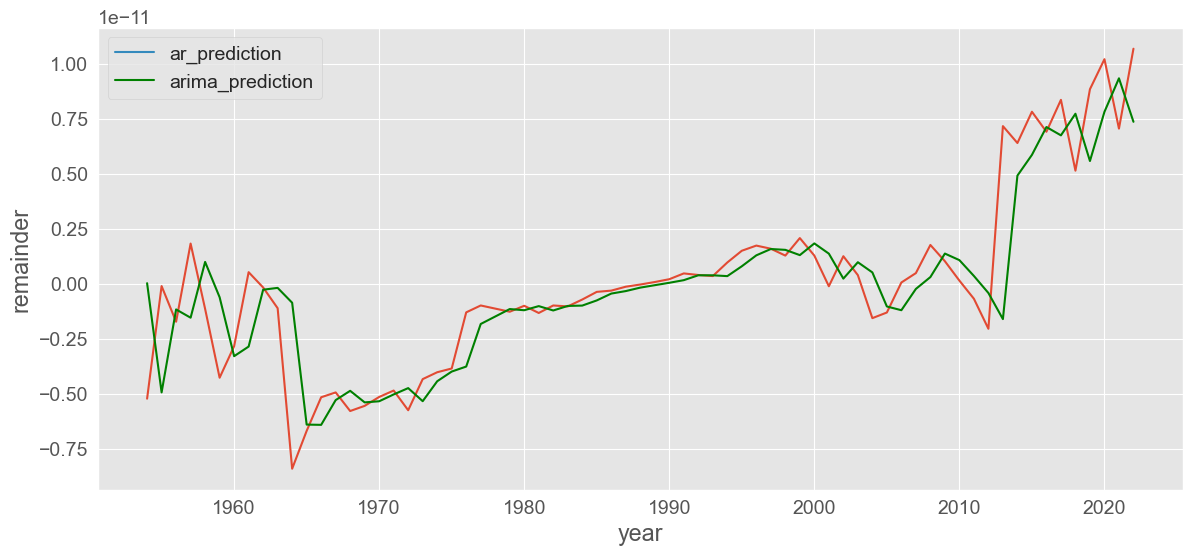

In [174]:
# Plot all time series remainder ar_predictions and arima_predictions
sns.lineplot(data)
sns.lineplot(ar_model.predict(), label="ar_prediction")
sns.lineplot(arima_model.predict(), label="arima_prediction",color='green')

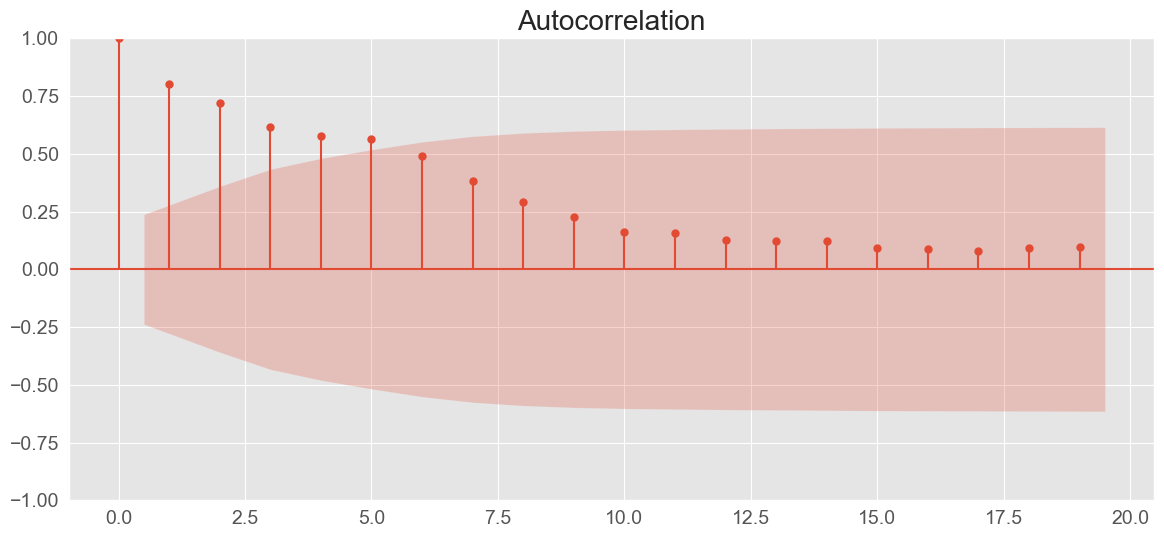

In [175]:
# Plot the autocorrelation between lags
plot_acf(data);

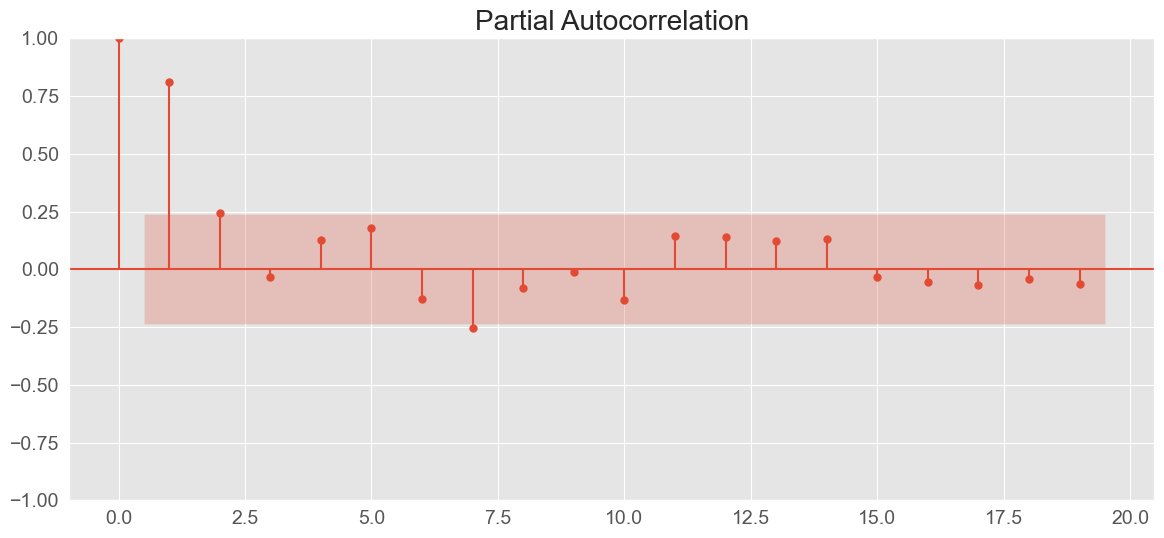

In [176]:
# Plot the partial autocorrelation between lags
plot_pacf(data);